In [2]:
import os
import time
import pandas as pd
import numpy as np
import openai
from tqdm import tqdm
import ast
tqdm.pandas() 

In [10]:
openai.api_key = os.getenv("OPENAI_API_KEY", None)

In [11]:
df_tagged_imgs = pd.read_csv("./tagged_dataset/final-tags.csv")
df_tagged_imgs = df_tagged_imgs.loc[:, ~df_tagged_imgs.columns.str.contains('^Unnamed')]
df_tagged_imgs.tail(2)

,image_name,image_path,tags,extended_tags
1308,280678d5-383f-450e-856e-08e2c11288e7.png,/media/pixis/pixis/Ravi_workspace/Entity-taggi...,"['circle', 'cotton candy', 'cube', 'green', 'h...","['top view of stone', ' focus on product', ' m..."
1309,891a97af-592f-4837-bd62-693793401ff7.png,/media/pixis/pixis/Ravi_workspace/Entity-taggi...,"['crack', 'marble', 'stone', 'white']","['kept on old shabby', ' corrosion', ' cracked..."


In [78]:
import ast
def get_tags_embeddings(tags_list):
    tags_list = ast.literal_eval(tags_list)
    tag_line = ', '.join(tags_list)
    embeddings = []
    response = openai.embeddings.create(input=tag_line, model="text-embedding-3-large")
    embeddings = response.data[0].embedding
    return embeddings

start_time = time.time()
df_tagged_imgs["tag_embeddings"] = df_tagged_imgs["extended_tags"].progress_apply(get_tags_embeddings)
end_time = time.time()
execution_time = end_time - start_time
# print(execution_time)

100%|██████████| 1310/1310 [16:54<00:00,  1.29it/s] 


In [34]:
embedded_tags_df.to_csv("./tagged_dataset/embedded_tags.csv")

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

def get_top_n_plots(top_image_paths):
    images_per_row = 3
    images = []
    for img_path in top_image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper color display
        images.append(img)

    # Total number of images
    total_images = len(images)

    # Calculate the number of rows needed
    rows = (total_images + images_per_row - 1) // images_per_row

    # Create a figure with the specified size
    fig, axes = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(12, rows * 3))

    # Loop through the images and plot them
    for idx, img in enumerate(images):
        row = idx // images_per_row
        col = idx % images_per_row
        axes[row, col].imshow(img)
        axes[row, col].axis('off')

    # Hide any empty subplots
    for i in range(total_images, rows * images_per_row):
        row = i // images_per_row
        col = i % images_per_row
        axes[row, col].axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

def get_top_n_similar_embeddings(new_embedding, tags_df, top_n=10):
    # Ensure the embeddings are in the correct format
    tag_embeddings = np.array(tags_df['tag_embeddings'].apply(ast.literal_eval).tolist())
    
    # Calculate the cosine similarity between the new embedding and the embeddings in the dataframe
    similarities = cosine_similarity([new_embedding], tag_embeddings)[0]
    
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    
    top_similarities = similarities[top_indices]
    top_embeddings = tags_df.iloc[top_indices]
    
    # Get the image file paths of the top_n most similar embeddings
    top_image_paths = top_embeddings['image_path'].tolist()
    
    return top_image_paths, top_similarities

def embed_query(input_query):
    input_query = ', '.join(input_query)
    response = openai.embeddings.create(input=input_query, model="text-embedding-3-large")
    embeddings = response.data[0].embedding
    return embeddings

In [27]:
def get_sorted_similar_embeddings(new_embedding, tags_df):
    # Ensure the embeddings are in the correct format
    tag_embeddings = np.array(tags_df['tag_embeddings'].apply(ast.literal_eval).tolist())
    similarities = cosine_similarity([new_embedding], tag_embeddings)[0]
    
    # Get the image file paths
    image_arrays = tags_df['image_array'].apply(ast.literal_eval).tolist()
    
    results = list(zip(image_arrays, similarities))
    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    
    # Separate the sorted image paths and similarity scores
    sorted_images = [result[0] for result in sorted_results]
    sorted_similarities = [result[1] for result in sorted_results]
    
    return sorted_images, sorted_similarities





In [15]:
df_tagged_imgs = df_tagged_imgs.loc[:, ~df_tagged_imgs.columns.str.contains('^Unnamed')]

In [20]:
query = ["fog"]
curr_embbedding = embed_query(query)

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

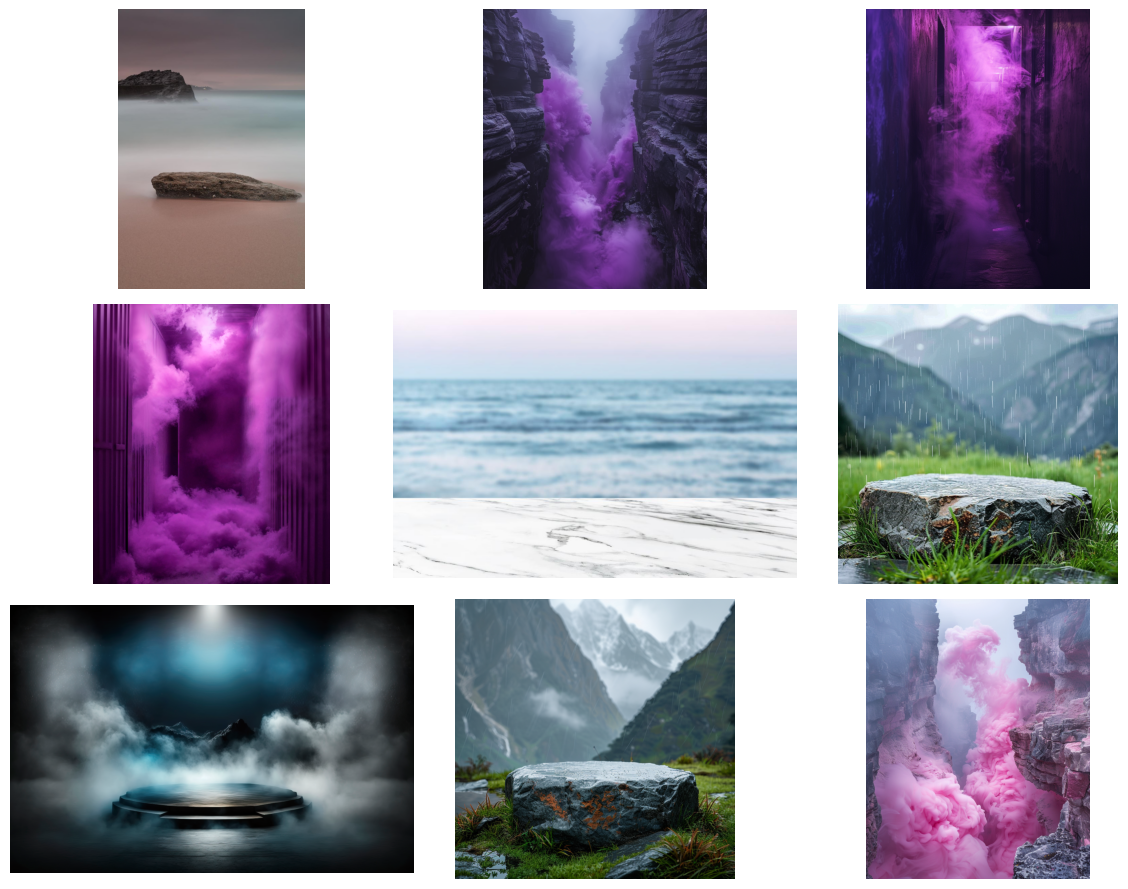

In [31]:
top_image_paths, top_similarities = get_top_n_similar_embeddings(curr_embbedding, embedded_tags, top_n=9)
get_top_n_plots(top_image_paths)

#### Create and save icons

In [7]:
def downscale_image(image_path, max_dimension=256):
    # Open the image
    image = Image.open(image_path)
    
    # Get the original dimensions
    original_width, original_height = image.size
    
    # Determine the scaling factor to downscale the longest dimension to max_dimension
    if original_width > original_height:
        scaling_factor = max_dimension / float(original_width)
    else:
        scaling_factor = max_dimension / float(original_height)
    
    # Calculate the new dimensions while maintaining the aspect ratio
    new_width = int(original_width * scaling_factor)
    new_height = int(original_height * scaling_factor)
    
    # Resize the image
    downscaled_image = image.resize((new_width, new_height), Image.LANCZOS)

    return downscaled_image

def get_icon_path(image_path):
    sub_path, image_name = os.path.split(image_path)
    image_uuid, ext = os.path.splitext(image_name)
    updated_image_name = image_uuid + "_icon" + ext
    final_image_path = os.path.join(sub_path, updated_image_name)
    return final_image_path


In [8]:
from PIL import Image
tagged_df = pd.read_csv("./tagged_dataset/final-tags.csv")

for index, row in tqdm(tagged_df.iterrows()):
    row = dict(row)
    image_path = row["image_path"]
    icon_save_path = get_icon_path(image_path)
    downscaled_image = downscale_image(image_path)

    downscaled_image.save(icon_save_path)
    

1310it [00:57, 22.76it/s]
